# Weather models : 2D parameters

The aim of this notebook is to indicate how to read the 2D data from weather models.
There are 2 weather models:
* a fine-mesh french weather model called 'AROME' (spatial resolution of 0.025°)
* a large-mesh french weather model called 'ARPEGE' (spatial resolution of 0.1°)

Per model, geographic zone ('NW' for North-West of France and 'SE' for South-East of France) and day, you have the model run of 00h with range forecasts from 00h to 24h. The time step is 1h.

Finally, the 2D data are stored in 4 different GRIB files, according to the vertical level:

* at 2m (*2m* in the file name) : temperature (in K), dew point temperature** (in K) and relative humidity (in %)
* at 10m (*10m* in the file name): wind speed (in m.s<sup>-1</sup>), wind direction (in degrees), U and V wind components*** (in m.s<sup>-1</sup>)
* at the sea level (*P_sea_level* in the file name) : mean sea level pressure (in Pa)
* at the ground level (*PRECIP* in the file name)  : total precipitation (in kg m<sup>-2</sup> which is equivalent to mm) since the beginning of the model run 


** : temperature for which it is needed to refresh an air volume at constant pressure and humidity to become it saturated (i.e. condensation temperature)<br/>
*** : horizontal wind speed components, U : from west to east and V : from south to north. 

For more information, cf [documentation](https://meteofrance.github.io/meteonet/english/data/weather-models/).

**/!\ : about the total precipitation parameter, the range forecast begins to 1h and not 0h as the other parameters. It is planned in a future version to modify that parameter in order to have the total precipitation between two time steps instead.**

When you open a GRIB file with the library xarray, a new associated file of type .idx is created. 

/!\ : Some files in the model files are incomplete/corrupted. It comes from the database of our corporation. There are archiving anomalies. We are working on a new version of MeteoNet and will take into account these anomalies. Meanwhile, you can detect these anomalies by checking the file sizes. For a given file category (zone, level, model type), the files must have exactly the same size. So if some files are smaller than the other one, then these files have anomalies. This has been reported in kaggle in this discussion https://www.kaggle.com/katerpillar/meteonet/discussion/157206 and in Github (https://github.com/meteofrance/meteonet/issues/14). 

In [1]:
import meteonet_toolbox.user_configuration
import xarray as xr
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import datetime as dt

User is not known. If you experiment some problems with path for library please add the specific path in `user_configuration.py` module


## Parameters definition

Select the area, model, date, level and parameter you want to study :

In [2]:
zone = "NW"     #geographic zone (NW or SE)
model = 'arome' #weather model (arome or arpege)
level = '2m'      #vertical level (2m, 10m, P_sea_level or PRECIP)
date = dt.datetime(2018, 5, 1,0,0) # Day example 
#parameter name in the file (cf cells below to know the parameter names -> exploration of metadata)
if level == '2m':
    param = 't2m'
elif level == '10m':
    param = 'u10'
elif level == 'PRECIP':
    param = 'tp'
else:
    param = 'msl'

## Loading data using parameters 

In [3]:
fname = "../../data_samples/weather_models/%s_%s_%s_%s.grib" % (model,level,zone,date.strftime('%Y%m%d%H%M%S'))
data = xr.open_dataset(fname, engine='cfgrib')  

## Quick field visualisation
The following comand shows the weather forecast at step 0 (analyse)  6/12/24 for temperature.
As the run chosed in parameter is the midnight run, the temperature at step 12 (figure 3) is the midday temperature. 
You can see that this temperature is higher than midnight (fig 1 and 4) or at 6AM (figure 2)

<IPython.core.display.Javascript object>


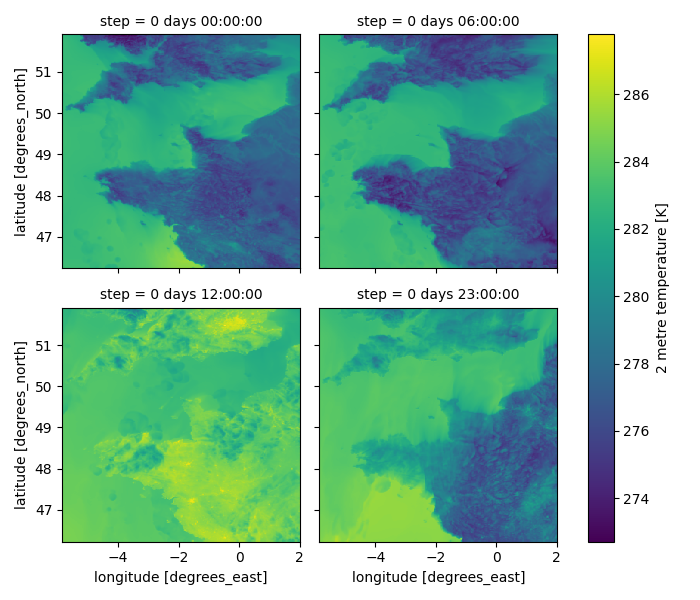

In [4]:
data.isel(step=[0, 6, 12, 23])[param].plot(x='longitude',
                                           y='latitude',
                                           col='step',
                                           col_wrap=2)

## Exploration of metadata 

Overview of the data :

In [ ]:
print(data)

Get the information about coordinates (latitude and longitude):

In [ ]:
coord = 'longitude'
data[coord]

In [ ]:
data[coord].units

In [ ]:
data[coord].values

Get the information about the run date and the different range forecasts:

In [ ]:
run_date = data['time']
#run_date.values     #get the values
run_date

In [ ]:
range_forecasts_dates = data['valid_time']
range_forecasts_dates

Get the information about the vertical level:

In [ ]:
if (level =='2m' or level == '10m'):
    level_name = 'heightAboveGround'
elif (level =='P_sea_level'):
    level_name = 'meanSea'
else:
    level_name = 'surface'
info_level = data[level_name]
info_level

Get the information about one parameter: 
the parameter names in the GRIB file are indicated in the field *Data variables* (cf print(data) above)

In [ ]:
d = data[param]     #param : parameter name defined at the beginning of the Notebook 
d_vals=d.values     #get the values
###examples to get the information from attributes
#d.units                      #unit
#d.long_name                      #long name
d

The structure of the parameter (3 dimensions):
* number of steps or range forecasts
* number of points in latitude
* number of points in longitude  

In [ ]:
d_vals.shape

## Plotting data with Cartopy

Plot the parameter values for 1 given time step with Cartopy:

In [ ]:
from meteonet_toolbox.constant import DOMAINS
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
#index for the studied time step
step = 0                

In [ ]:
#coordinates of study zone boundaries
lllat=DOMAINS[zone]['lry']    #lower left latitude
urlat=DOMAINS[zone]['uly']    #upper right latitude
lllon=DOMAINS[zone]['ulx']    #lower left longitude
urlon=DOMAINS[zone]['lrx']    #upper right longitude
extent = [lllon, urlon, lllat, urlat]

In [ ]:
fig=plt.figure(figsize=(9,10))

# Select projection
ax = plt.axes(projection=ccrs.PlateCarree())

#plot the data and the background map (coastlines and borders)
img = ax.imshow(d_vals[step,:,:], interpolation='none', origin='upper', extent=extent)
ax.coastlines(resolution='50m', linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'))


plt.colorbar(img, orientation= 'horizontal').set_label(d.long_name+ ' (in '+d.units+ ')')
plt.title(model +" model - "+str(d['valid_time'].values[step])+" - " +zone + " zone")
plt.show()